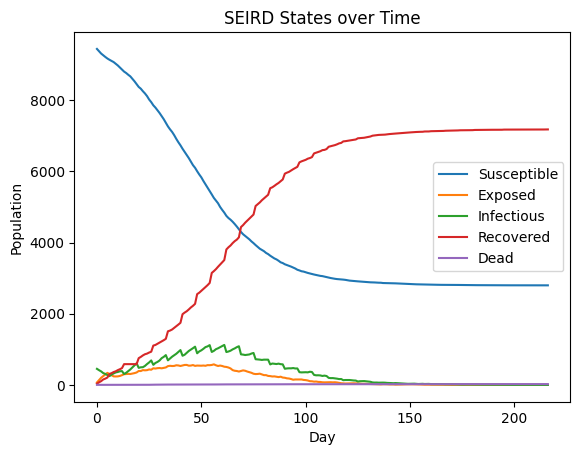

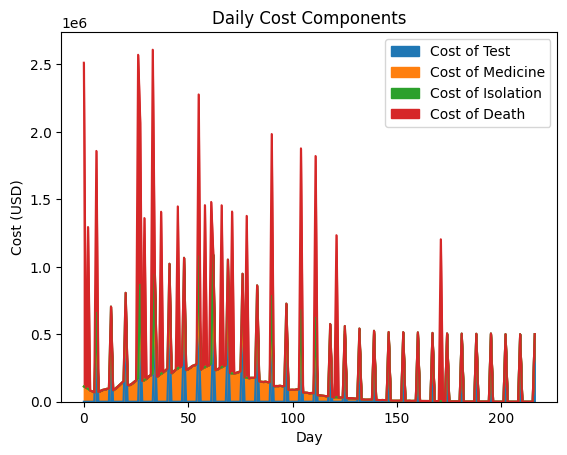

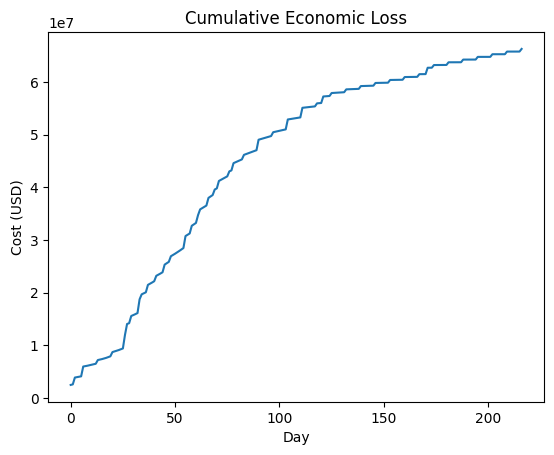


=== Summary ===
Total Loss (M$)   : 66.25
Testing (%)       : 23.4%
Medical (%)       : 29.3%
Isolation (%)     : 5.7%
Death (%)         : 41.7%
Total Deaths      : 23
Total Isolations  : 7
Epidemic Days     : 217


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm.auto import tqdm

"""
Baseline experiment: default parameters with testing_enabled = True / False
"""

# ------------------------- Agent ------------------------- #
class SEIRDAgent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        self.state = "S"
        self.days_in_state = 0

    def step(self):
        if self.state == "S":
            self.try_infection()

        elif self.state == "E":
            self.days_in_state += 1
            if self.days_in_state >= self.model.incubation_period:
                self.state, self.days_in_state = "I", 0

        elif self.state == "I":
            self.days_in_state += 1
            if self.days_in_state >= self.model.recovery_period:
                if self.random.random() < self.model.death_prob:
                    self.state = "D"
                    self.model.deaths_today += 1
                else:
                    self.state = "R"
                self.days_in_state = 0  # reset counter

    def try_infection(self):
        other = self.random.choice(self.model.agents)
        if other.state == "I" and self.random.random() < self.model.infection_prob:
            self.state, self.days_in_state = "E", 0


# ------------------------- Model ------------------------- #
class SEIRDModel(mesa.Model):
    def __init__(self, *,
                 population=10000,
                 initial_infection_rate=0.05,
                 infection_prob=0.15,
                 incubation_period=5.5,
                 recovery_period=14,
                 death_prob=0.005,
                 testing_enabled=True,
                 testing_interval=7,
                 testing_prob=0.2,
                 seed=42,
                 c_test=50,
                 c_inf=250,
                 c_death=1.2e6,
                 c_iso=1_500):     # default parameters: COVID-19 Baseline

        super().__init__(seed=seed)

        # ---- Transmission & testing params ---- #
        self.infection_prob = infection_prob
        self.incubation_period = incubation_period
        self.recovery_period = recovery_period
        self.death_prob = death_prob
        self.testing_enabled = testing_enabled
        self.testing_interval = testing_interval
        self.testing_prob = testing_prob

        # ---- Cost params ---- #
        self.c_test = c_test
        self.c_inf = c_inf
        self.c_death = c_death
        self.c_iso = c_iso               

        # ---- Daily countors ---- #
        self.tests_today = 0
        self.deaths_today = 0
        self.isolations_today = 0       

        # ---- Cumulative cost ---- #
        self.total_cost = 0.0

        # ---- Agent creation ---- #
        for _ in range(population):
            agent = SEIRDAgent(self)
            if self.random.random() < initial_infection_rate:
                agent.state = "I"
                agent.days_in_state = self.random.randint(0, recovery_period - 1)

        # ---- DataCollector ---- #
        self.datacollector = DataCollector(
            model_reporters={
                # --- SEIRD States ---
                "Susceptible": lambda m: m.count_state("S"),
                "Exposed": lambda m: m.count_state("E"),
                "Infectious": lambda m: m.count_state("I"),
                "Recovered": lambda m: m.count_state("R"),
                "Dead": lambda m: m.count_state("D"),
                # --- Cost breakdown ---
                "Cost of Test":  lambda m: m.daily_test_cost,
                
                "Cost of Medicine":   lambda m: m.daily_inf_cost,
                "Cost of Isolation":   lambda m: m.daily_iso_cost, 
                "Cost of Death": lambda m: m.daily_death_cost,
                "Cost of Total": lambda m: m.daily_cost,
                "CumCost":   lambda m: m.total_cost,
            }
        )

    def count_state(self, state):
        return sum(a.state == state for a in self.agents)

    # -------------- Main loop -------------- #
    def step(self):
        # ------ reset ------
        self.tests_today = 0
        self.deaths_today = 0
        self.isolations_today = 0

        # 1. Agent action
        self.agents.shuffle_do("step")

        # 2. test & isolation
        self.apply_testing()

        # 3. Calculate costs
        I_t = self.count_state("I")
        self.daily_test_cost  = self.c_test * self.tests_today
        self.daily_inf_cost   = self.c_inf  * I_t
        self.daily_iso_cost   = self.c_iso  * self.isolations_today   # ★ 新增
        self.daily_death_cost = self.c_death * self.deaths_today

        self.daily_cost = (self.daily_test_cost + self.daily_inf_cost +
                           self.daily_iso_cost + self.daily_death_cost)
        self.total_cost += self.daily_cost

        # 4. Report
        self.datacollector.collect(self)

    # --------------- Virus test --------------- #
    def apply_testing(self):
        if self.testing_enabled and self.steps % self.testing_interval == 0:
            for agent in self.agents:
                self.tests_today += 1
                if agent.state == "I" and self.random.random() < self.testing_prob:
                    # Positive → isolation
                    self.isolations_today += 1             
                    agent.state, agent.days_in_state = "R", 0


# ------------------------- running ------------------------- #

def experiment(model):
    is_epidemic = True
    days = 0

    while is_epidemic:
        model.step()
        df = model.datacollector.get_model_vars_dataframe()
        days += 1
        if df.tail(1)['Infectious'].all() == 0 and df.tail(1)['Exposed'].all() == 0:
            is_epidemic = False


    # —— 1: SEIRD statistic —— #
    df[["Susceptible", "Exposed", "Infectious", "Recovered", "Dead"]].plot()
    plt.title("SEIRD States over Time")
    plt.xlabel("Day")
    plt.ylabel("Population")
    plt.show()

    # —— 2: Daily cost breakdown —— #
    df[["Cost of Test", "Cost of Medicine", "Cost of Isolation", "Cost of Death"]].plot.area()
    plt.title("Daily Cost Components")
    plt.xlabel("Day")
    plt.ylabel("Cost (USD)")
    plt.show()

    # —— 3: Cumulative loss —— #
    df["CumCost"].plot()

    plt.title("Cumulative Economic Loss")
    plt.xlabel("Day")
    plt.ylabel("Cost (USD)")
    plt.show()

    # —— Key metrics —— #
    summary = {
        "Total Loss (M$)": round(model.total_cost / 1e6, 2),
        "Testing (%)": f'{df["Cost of Test"].sum() / model.total_cost:.1%}',
        "Medical (%)": f'{df["Cost of Medicine"].sum()  / model.total_cost:.1%}',
        "Isolation (%)": f'{df["Cost of Isolation"].sum() / model.total_cost:.1%}',
        "Death (%)": f'{df["Cost of Death"].sum()/ model.total_cost:.1%}',
        "Total Deaths": int(df["Dead"].iloc[-1]),
        "Total Isolations": int(df["Cost of Isolation"].count() * model.isolations_today // max(1, model.steps // model.testing_interval)),
        "Epidemic Days": int(days)
    }
    print("\n=== Summary ===")
    for k, v in summary.items():
        print(f"{k:18}: {v}")

experiment(SEIRDModel())

Testing interval: 100%|██████████| 5/5 [3:10:57<00:00, 2291.49s/it]  


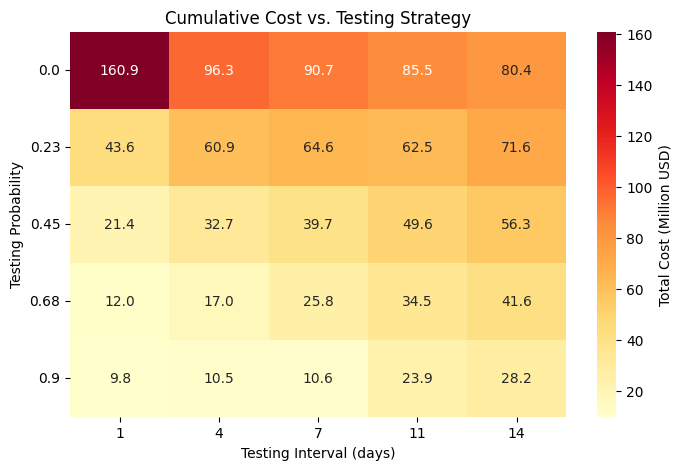

In [ ]:
from itertools import product

"""
Factorial grid experiment
"""

def run_once(t_int, t_prob, seed):
    model = SEIRDModel(
        testing_enabled=True,
        testing_interval=t_int,
        testing_prob=t_prob,
        seed=seed
    )
    while True:
        model.step()
        if model.count_state("E") == 0 and model.count_state("I") == 0:
            break
    return model.total_cost

interval_grid = [1, 4, 7, 11, 14]
prob_grid = [0.00, 0.23, 0.45, 0.68, 0.90]
param_grid = product(interval_grid, prob_grid)
reps = 5                  
n_jobs = -1               

results = []                        

for t_int, t_prob in tqdm(param_grid, desc="Testing parameter combinations", total=len(interval_grid)*len(prob_grid)):
    costs = Parallel(n_jobs=n_jobs)(
        delayed(run_once)(t_int, t_prob, seed)
        for seed in range(reps)
    )
    results.append({
        "interval": t_int,
        "prob": t_prob,
        "cost": np.mean(costs)  
    })

df_cost = pd.DataFrame(results)

cost_matrix = df_cost.pivot(index="prob", columns="interval", values="cost") / 1e6
plt.figure(figsize=(8, 5))  
sns.heatmap(cost_matrix, annot=True, fmt=".1f", cmap="YlOrRd",
            cbar_kws={"label": "Total Cost (Million USD)"})
plt.title("Cumulative Cost vs. Testing Strategy")
plt.xlabel("Testing Interval (days)")
plt.ylabel("Testing Probability")
plt.yticks(rotation=0)
plt.show()